In [1]:
import os 
import numpy as np
import pandas as pd
import scipy
import sklearn.metrics as skmetrics

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, Dataset
import lightning as L

import torchmetrics
from torchmetrics.regression import PearsonCorrCoef

In [2]:
os.chdir("bc_deep_learning_in_biology")

FileNotFoundError: [Errno 2] No such file or directory: 'bc_deep_learning_in_biology'

In [3]:
aa_alphabet = 'ACDEFGHIKLMNPQRSTVWY' # amino acid alphabet
aa_to_int = {aa: i for i, aa in enumerate(aa_alphabet)} # mapping from amino acid to number

# function to one hot encode sequence
def one_hot_encode(sequence):
    # initialize a zero matrix of shape (len(sequence), len(amino_acids))
    one_hot = torch.zeros(len(sequence), len(aa_alphabet))
    for i, aa in enumerate(sequence):
        # set the column corresponding to the amino acid to 1
        one_hot[i].scatter_(0, torch.tensor([aa_to_int[aa]]), 1)
    return one_hot


# sequence data, comes already batched, so treat accordingly in dataloader (batch_size=1)
class SequenceData(Dataset):
    def __init__(self, csv_file, label_col="ddG_ML"):
        """
        Initializes the dataset. 
        input:
            csv_file: path to the relevant data file, eg. "/home/data/mega_train.csv"
        """
        self.df = pd.read_csv(csv_file, sep=",")
        self.label_col = label_col
        # only have mutation rows
        self.df = self.df[self.df.mut_type!="wt"]
        # process the mutation row
        self.df["mutation_pos"] = self.df["mut_type"].apply(lambda x: int(x[1:-1])-1) # make position start at zero 
        self.df["mutation_to"] = self.df["mut_type"].apply(lambda x: aa_to_int[x[-1]]) # give numerical label to mutation
        self.min = 72

        # group by wild type
        self.df = self.df.groupby("WT_name").agg(list)
        # get wild type names
        self.wt_names = self.df.index.values
        # precompute one-hot encoding for faster training
        self.encoded_seqs = {}
        for wt_name in self.wt_names:
            # get the correct row
            mut_row = self.df.loc[wt_name]
            seq = mut_row["wt_seq"][0]
            self.encoded_seqs[wt_name] = one_hot_encode(seq)
                

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get the wild type name
        wt_name = self.wt_names[idx]
        # get the correct row
        mut_row = self.df.loc[wt_name]
        # get the wt sequence in one hot encoding
        sequence_encoding = self.encoded_seqs[wt_name]

        # create mask and target tensors
        mask = torch.zeros((1, len(sequence_encoding),20)) # will be 1 where we have a measurement
        target = torch.zeros((1, len(sequence_encoding),20)) # ddg values
        # all mutations from df
        positions = torch.tensor(mut_row["mutation_pos"])
        amino_acids = torch.tensor(mut_row["mutation_to"])
        # get the labels
        labels = torch.tensor(mut_row[self.label_col])

        for i in range(len(sequence_encoding)):
            mask[0,i,amino_acids[positions==i]] = 1 # one where we have data
            target[0,i,amino_acids[positions==i]] = labels[positions==i] # fill with ddG values
        
        # returns encoded sequence, mask and target sequence 
        return {"sequence": sequence_encoding[None,:,:].float(), "mask": mask, "labels": target}

In [4]:
dataset_train = SequenceData('project_data/mega_train.csv')
dataset_val= SequenceData('project_data/mega_val.csv')
dataset_test = SequenceData('project_data/mega_test.csv')

# use batch_size=1 bc we treat each sequence as one batch
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=False)
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=1, shuffle=False)

FileNotFoundError: [Errno 2] No such file or directory: 'project_data/mega_train.csv'

In [24]:
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyLSTM,self).__init__()
        
        # save input parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size # number of amino acids
        
        self.lin0 = nn.Linear(input_size, input_size)
       
        # define model layers (LSTM) (pseudocode:)
        self.LSTM = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.lin1 = nn.Linear(hidden_size, output_size)

        
    def forward(self,inp):
        inp1 = inp.to(inp.device).double()
        inp1 = self.lin0(inp1).to(inp.device).double()
        
        #hidden state
        h_0 = torch.zeros(1,inp1.size(0),self.hidden_size).double().to(inp.device)
        #cell state
        c_0 = torch.zeros(1,inp1.size(0),self.hidden_size).double().to(inp.device)
        
        output_LSTM, _ = self.LSTM(inp1,(h_0,c_0))
        output = self.lin1(output_LSTM).to(inp.device)
        
        
        return output
        

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SequenceModelLightning(L.LightningModule):
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        super().__init__()
        self.model = MyLSTM(input_size, hidden_size, output_size).double()
        self.lr = lr
        # define loss function
        self.loss = nn.RMSELoss(reduction="mean")

    def forward(self, x):
        return self.model(x)
        # define accuracy metric (torchmetrics)
        #self.accuracy = torchmetrics.classification.MulticlassAccuracy() #change
        ########################

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        ######### TODO #############
        
        # read from batch
        mask, labels, sequence = batch["mask"][0].double(), batch["labels"][0].double(), batch["sequence"][0].double()

        # run data through model
        predictions = self.model(sequence)
        
        # compute loss
        loss = self.loss(predictions[mask==1],labels[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions, y)
        ##############################

        # logging the values (will appear in progress bar and on dashboard)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("train_acc", acc, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
        ############## TODO ################
        # define the optimizer, let's use Adam
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        ####################################
        return optimizer

    def test_step(self, batch, batch_idx):
        # this is the test loop

        ############### TODO #############
        # read from batch
        mask, labels, sequence = batch["mask"][0].double(), batch["labels"][0].double(), batch["sequence"][0].double()
        # run data through model
        predictions = self.model(sequence)
        
        # compute loss
        loss = self.loss(predictions[mask==1],labels[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("test_loss", loss, prog_bar=True)
        #self.log("test_acc", acc, prog_bar=True)
        return loss#, acc


    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        ############### TODO #############
        # read from batch
        mask, labels, sequence = batch["mask"][0].double(), batch["labels"][0].double(), batch["sequence"][0].double()
        
        # run data through model
        predictions = self.model(sequence)
        
        
        # compute loss
        loss = self.loss(predictions[mask==1],labels[mask==1])
        # compute accuracy
        #acc = self.accuracy(predictions,y)
        ##############################

        # logging
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        #self.log("val_acc", acc, on_epoch=True, prog_bar=True)
        return loss 

In [35]:
# define the model and training loop
lit_model = SequenceModelLightning(input_size = 20,
                                  hidden_size = 24,
                                  output_size = 20,
                                  lr = 1e-3)

# define the trainer
trainer = L.Trainer(devices = 1, 
                    max_epochs = 20)

# learn the weights of the model
trainer.fit(lit_model, dataloader_train, dataloader_val)

AttributeError: module 'torch.nn' has no attribute 'RMSELoss'

In [36]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/ --host localhost --port=8001

Reusing TensorBoard on port 8001 (pid 3302884), started 0:07:54 ago. (Use '!kill 3302884' to kill it.)

RMSE: 0.7751400768246743
Pearson r: PearsonRResult(statistic=0.5534276963122396, pvalue=0.0)
Spearman r: SignificanceResult(statistic=0.5127038314610062, pvalue=0.0)


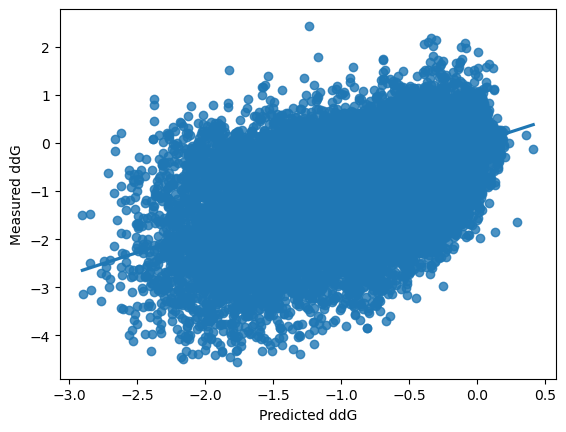

In [33]:
preds =[]
all_y = []

for batch in dataloader_val:
    # read from batch
    x = batch["sequence"][0]
    mask = batch["mask"][0]
    target = batch["labels"][0]
    ## adjust to work with your model
    # predict
    prediction = lit_model(x)
    preds.append(prediction[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence
    all_y.append(target[mask==1].flatten().detach().numpy()) # flatten to create one dimensional vector from 2D sequence

# concatenate and plot
preds= np.concatenate(preds)
all_y = np.concatenate(all_y)

sns.regplot(x=preds,y=all_y)
plt.xlabel("Predicted ddG")
#plt.xlim(-4.75, 2.75)
plt.ylabel("Measured ddG")
#plt.ylim(-4.75, 2.75)
# get RMSE, Pearson and Spearman correlation 
print("RMSE:", skmetrics.mean_squared_error(all_y, preds, squared = False))
print("Pearson r:", scipy.stats.pearsonr(preds, all_y))
print("Spearman r:", scipy.stats.spearmanr(preds, all_y))